Source: http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

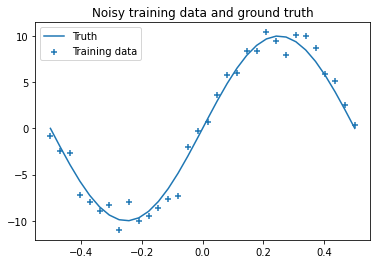

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def f(x, sigma):
    epsilon = np.random.randn(*x.shape) * sigma
    return 10 * np.sin(2 * np.pi * (x)) + epsilon

train_size = 32
noise = 1.0

X = np.linspace(-0.5, 0.5, train_size).reshape(-1, 1)
y = f(X, sigma=noise)
y_true = f(X, sigma=0.0)

plt.scatter(X, y, marker='+', label='Training data')
plt.plot(X, y_true, label='Truth')
plt.title('Noisy training data and ground truth')
plt.legend();

The noise in training data gives rise to **aleatoric uncertainty**. To cover **epistemic uncertainty** we implement the variational inference logic in a custom DenseVariational Keras layer. The complexity cost (kl_loss) is computed layer-wise and added to the total loss with the add_loss method. 

In [ ]:
from keras import backend as K
from keras import activations, initializers
from keras.layers import Layer

import tensorflow as tf
import tensorflow_probability as tfp

class DenseVariational(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 # mix of prior Gausssian distribution
                 prior_sigma_1=1.5, 
                 prior_sigma_2=0.1,
                 # weight of the mixed Gaussian
                 prior_pi=0.5, **kwargs):
        
        self.units = units # output size of the layer
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.init_sigma = np.sqrt(self.prior_pi_1 * self.prior_sigma_1 ** 2 +
                                  self.prior_pi_2 * self.prior_sigma_2 ** 2)
        
        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.units
    
    # build the variational inference layer
    # each layer consists of wright and bias
    # weight and bias are reparameterised by (mu, rho)
    def build(self, input_shape):
        # mu
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.init_sigma),
                                         trainable=True)
        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.init_sigma),
                                       trainable=True)
        
        # rho
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.constant(0.0),
                                          trainable=True)
        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.constant(0.0),
                                        trainable=True)
        super().build(input_shape)
    
    # append the layers
    def call(self, inputs, **kwargs):
        
        # sample from the variational distribution
        kernel_sigma = tf.math.softplus(self.kernel_rho) # positive sigma
        kernel = self.kernel_mu + kernel_sigma * tf.random.normal(self.kernel_mu.shape)

        bias_sigma = tf.math.softplus(self.bias_rho)
        bias = self.bias_mu + bias_sigma * tf.random.normal(self.bias_mu.shape)
        
        # add loss upon the compile loss for both weight and bias
        self.add_loss(self.kl_loss(kernel, self.kernel_mu, kernel_sigma) +
                      self.kl_loss(bias, self.bias_mu, bias_sigma))

        return self.activation(K.dot(inputs, kernel) + bias)
    
    """
    the KL loss can be written as:
    log(q(w|theta)) - log(P(w))
    """

    # find KL divergence
    def kl_loss(self, w, mu, sigma):
        # w: sampled from variational distribution
        # mu, sigma: learnt from the last run
        variational_dist = tfp.distributions.Normal(mu, sigma) # log(q(w|theta)), of size no. of weight
        return self.kl_weight * K.sum(variational_dist.log_prob(w) - self.log_prior_prob(w))
    
    def log_prior_prob(self, w):
        comp_1_dist = tfp.distributions.Normal(0.0, self.prior_sigma_1)
        comp_2_dist = tfp.distributions.Normal(0.0, self.prior_sigma_2)
        return K.log(self.prior_pi_1 * comp_1_dist.prob(w) +
                     self.prior_pi_2 * comp_2_dist.prob(w)) # of size no. of weights

Instead of modeling a full probability distribution p(y|x,w) as output the network simply outputs the mean of the corresponding Gaussian distribution. In other words, we do not model aleatoric uncertainty here and assume it is known. We only model epistemic uncertainty via the DenseVariational layers.

Since the training dataset has only 32 examples we train the network with all 32 examples per epoch so that the number of batches per epoch is 1. For other configurations, the complexity cost (kl_loss) must be weighted by **1/M** as described in section 3.4 of the paper where M is the number of mini-batches per epoch. The hyper-parameter values for the mixture prior, prior_params, have been chosen to work well for this example and may need adjustments in another context.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from keras.layers import Input
from keras.models import Model

batch_size = train_size
num_batches = train_size / batch_size

kl_weight = 1.0 / num_batches
prior_params = {
    'prior_sigma_1': 1.5, 
    'prior_sigma_2': 0.1, 
    'prior_pi': 0.5 
}

# initialize the model
x_in = Input(shape=(1,))
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x_in)
x = DenseVariational(20, kl_weight, **prior_params, activation='relu')(x)
x = DenseVariational(1, kl_weight, **prior_params)(x)

model = Model(x_in, x)

# likelihood loss
from keras import callbacks, optimizers

# fixed standard deviation
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs)) # because the KL loss is sum

model.compile(loss=neg_log_likelihood, optimizer=tf.keras.optimizers.Adam(lr=0.08), metrics=['mse'])
model.fit(X, y, batch_size=batch_size, epochs=1500, verbose=1);

Epoch 1/1500
1/1 [==============================] - 6s 6s/step - loss: 1288.7129 - mse: 48.4455
Epoch 2/1500
1/1 [==============================] - 0s 13ms/step - loss: 7340.4814 - mse: 429.5736
Epoch 3/1500
1/1 [==============================] - 0s 10ms/step - loss: 3445.0725 - mse: 188.1359
Epoch 4/1500
1/1 [==============================] - 0s 19ms/step - loss: 3413.4727 - mse: 183.2699
Epoch 5/1500
1/1 [==============================] - 0s 24ms/step - loss: 1789.0391 - mse: 80.9950
Epoch 6/1500
1/1 [==============================] - 0s 12ms/step - loss: 2522.2354 - mse: 128.4699
Epoch 7/1500
1/1 [==============================] - 0s 15ms/step - loss: 3014.2942 - mse: 159.4294
Epoch 8/1500
1/1 [==============================] - 0s 17ms/step - loss: 5717.1313 - mse: 329.4888
Epoch 9/1500
1/1 [==============================] - 0s 24ms/step - loss: 993.9477 - mse: 34.2811
Epoch 10/1500
1/1 [==============================] - 0s 12ms/step - loss: 9277.7227 - mse: 551.8423
Epoch 11/1500
1

When calling `model.predict` we draw a random sample from the variational posterior distribution and use it to compute the output value of the network. This is equivalent to obtaining the output from a single member of a hypothetical ensemble of neural networks. Drawing 500 samples means that we get predictions from 500 ensemble members. From these predictions we can compute statistics such as the mean and standard deviation. In our example, the standard deviation is a measure of **epistemic uncertainty**.

100%|██████████| 500/500 [00:56<00:00,  8.84it/s]


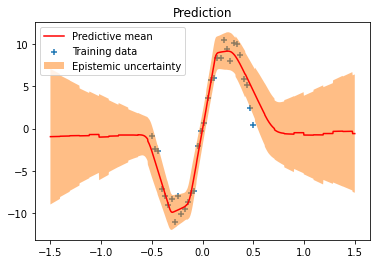

In [ ]:
# evaluation
import tqdm

X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm(range(500)):
    y_pred = model.predict(X_test)
    y_pred_list.append(y_pred)

y_preds = np.concatenate(y_pred_list, axis=1)

y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

plt.plot(X_test, y_mean, 'r-', label='Predictive mean');
plt.scatter(X, y, marker='+', label='Training data')
plt.fill_between(X_test.ravel(), 
                 y_mean + 2 * y_sigma, 
                 y_mean - 2 * y_sigma, 
                 alpha=0.5, label='Epistemic uncertainty')
plt.title('Prediction')
plt.legend();

We can clearly see that epistemic uncertainty is much higher in **regions of no training data** than it is in regions of existing training data. The predictive mean could have also been obtained with a single forward pass i.e. a single `model.predict` call by using only the mean of the variational posterior distribution which is equivalent to sampling from the variational posterior with σ set to 0.

In [ ]:
y_pred = model(X)
nll_loss = neg_log_likelihood(y, y_pred)
print(nll_loss)

tf.Tensor(84.34356, shape=(), dtype=float32)
